# Overview

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$. This entails passing on information about $\alpha$ and $\beta$ to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of $|\psi\rangle$ and give the copy to Bob. WE can only copy classical states (not superpositions).

However, by taking advantage of two classical bits an an entangled qubit pair, Alice can transfer her state $|\psi\rangle$ to Bob. We call this teleportation because, at the end, Bob will have $|\psi\rangle$ and Alice won't anymore. 

# Quantum Teleportation Protocol

To transfer a quantum bit, Alice and Bob must use a third party to send them an entangled qubit pair. Alice then performs some operations on her qubit pair, send the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice's qubit. 

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

In [2]:
qr = QuantumRegister(3, name = "q") # Protocol uses 3 qubits
crz = ClassicalRegister(1, name = "crz") # and 2 classical bits
crx = ClassicalRegister (1, name = "crx") # in 2 different registers
teleportation_circuits = QuantumCircuit (qr, crz, crx)

### Step 1

A third party, Telamon creates an entangled pair of qubits and gives one to Bob and one to Alice. This is the Bell Pair. In QC language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a and b"""
    qc.h(a) # Put qbit a into state |+>
    qc.cx(a, b) # CNOT with a as a control and b as a target. 

In [4]:

## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

### Step 2

Alice applies a CNOT gate to $q_1$, controlled by $|\psi\rangle$ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to $|\psi\rangle$. In our quantum circuit, the qubit Alice is trying to send ($|\psi\rangle$) is $q_0$

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [6]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

### Step 3

Next, Alice applies a measurement to both qubits she owns, $q_1$ and $|\psi\rangle$ and stores this result in two classical qubits. She then sends these two qubits to Bob.


In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [8]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
crx: 1/══════════════════════════════╩═
                                     0

### Step 4

Bob, who already has qubit $q_2$ then applies the following gates depending on the state of the classical bits:

00 -> Do Nothing

01 -> Apply X Gate

10 -> Apply Z Gate

11 -> Apply ZX Gate

In [9]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'


<img src = 'teleport.png' width = 500/>

In [10]:

## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                  ║  ║       ║   ┌──╨──┐
crz: 1/═══════════════════════════╩══╬═══════╬═══╡ 0x1 ╞
                                  0  ║    ┌──╨──┐└─────┘
crx: 1/══════════════════════════════╩════╡ 0x1 ╞═══════
                                     0    └─────┘

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

# Simulating the Teleportation Protocol

In this ntoebook, we will initialize Alice's qubit in a random state $|\psi\rangle$ (psi). The state will be created using an Initialize gate on $|q_0\rangle$. In this chapter, we use this function ```random_statevector``` to choose psi for us, but feel free to set psi to any qubit.

<IPython.core.display.Latex object>

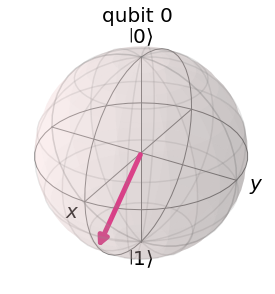

In [11]:
# Create random 1-qubit state 

psi = random_statevector(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
plot_bloch_multivector(psi)

In [12]:
init_gate = Initialize(psi)
init_gate.label = "init"

In [13]:

## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

┌─────────────────────────────────────────┐ ░            ░      ┌───┐ ░ »
  q_0: ┤ init(0.31401+0.24102j,0.76628+0.50609j) ├─░────────────░───■──┤ H ├─░─»
       └─────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ »
  q_1: ────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─»
                                                   ░ └───┘┌─┴─┐ ░ └───┘      ░ »
  q_2: ────────────────────────────────────────────░──────┤ X ├─░────────────░─»
                                                   ░      └───┘ ░            ░ »
crz: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
crx: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
«       ┌─┐                 
«  q_0: ┤M├─────────────────
«       └╥┘┌─┐              
«  q_1: ─╫─┤M├──────────────
«        ║ └╥┘ ┌───┐  ┌───┐ 
«  q_2: ─╫──╫──┤ X ├──┤ Z ├─
«        ║  ║  └─╥─┘  └─╥─┘ 
«        ║  ║    ║   ┌──╨──┐
«crz: 1/═╩══╬════╬═══╡ 0x1 ╞
«        0  ║ ┌──╨──┐└─────┘
«crx: 1/════╩═╡ 0x1 ╞═══════
«           0 └─────┘

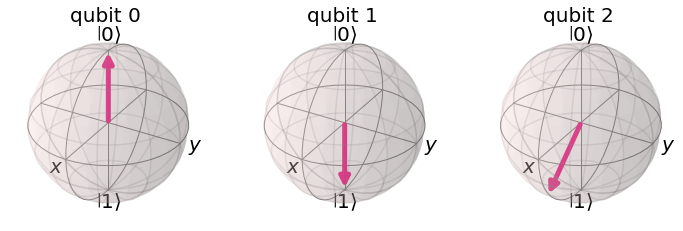

In [14]:

sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

In [15]:
inverse_init_gate = init_gate.gates_to_uncompute()


In [16]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

┌─────────────────────────────────────────┐ ░            ░      ┌───┐ ░ »
  q_0: ┤ init(0.31401+0.24102j,0.76628+0.50609j) ├─░────────────░───■──┤ H ├─░─»
       └─────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ »
  q_1: ────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─»
                                                   ░ └───┘┌─┴─┐ ░ └───┘      ░ »
  q_2: ────────────────────────────────────────────░──────┤ X ├─░────────────░─»
                                                   ░      └───┘ ░            ░ »
crz: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
crx: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
«       ┌─┐                                 
«  q_0: ┤M├─────────────────────────────────
«       └╥┘┌─┐                              
«  q_1: ─╫─┤M├──────────────────────────────
«        ║ └╥┘ ┌───┐  ┌───┐ ┌──────────────┐
«  q_2: ─╫──╫──┤ X ├──┤ Z ├─┤ disentangler ├
«        ║  ║  └─╥─┘  └─╥─┘ └──────────────┘
«        ║  ║    ║   ┌──╨──┐                
«crz: 1/═╩══╬════╬═══╡ 0x1 ╞════════════════
«        0  ║ ┌──╨──┐└─────┘                
«crx: 1/════╩═╡ 0x1 ╞═══════════════════════
«           0 └─────┘

In [17]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

┌─────────────────────────────────────────┐ ░            ░      ┌───┐ ░ »
  q_0: ┤ init(0.31401+0.24102j,0.76628+0.50609j) ├─░────────────░───■──┤ H ├─░─»
       └─────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ »
  q_1: ────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─»
                                                   ░ └───┘┌─┴─┐ ░ └───┘      ░ »
  q_2: ────────────────────────────────────────────░──────┤ X ├─░────────────░─»
                                                   ░      └───┘ ░            ░ »
crz: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
crx: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
 c0: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
«       ┌─┐                                    
«  q_0: ┤M├────────────────────────────────────
«       └╥┘┌─┐                                 
«  q_1: ─╫─┤M├─────────────────────────────────
«        ║ └╥┘ ┌───┐  ┌───┐ ┌──────────────┐┌─┐
«  q_2: ─╫──╫──┤ X ├──┤ Z ├─┤ disentangler ├┤M├
«        ║  ║  └─╥─┘  └─╥─┘ └──────────────┘└╥┘
«        ║  ║    ║   ┌──╨──┐                 ║ 
«crz: 1/═╩══╬════╬═══╡ 0x1 ╞═════════════════╬═
«        0  ║ ┌──╨──┐└─────┘                 ║ 
«crx: 1/════╩═╡ 0x1 ╞════════════════════════╬═
«           0 └─────┘                        ║ 
« c0: 1/═════════════════════════════════════╩═
«                                            0

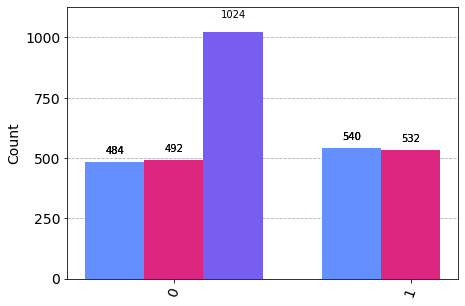

In [21]:
t_qc = transpile(qc, sim)
t_qc.save_statevector()
qobj = assemble(t_qc)
counts = sim.run(qobj).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)